### Process Caucasus DZ Data ###
This notebook uses the accompanying dz module (dz.py) to process compiled Caucasus DZ data.

In [1]:
# Imports - run first
import pandas as pd
import numpy as np

import dz

This cell reads in the data from the Metadata table and creates DZ sample objects

In [3]:
# Import Data and Create DZ Objects
metadata = pd.read_excel('Metadata-Table-Caucasus.xlsx')

names = metadata['Sample Name']
sources = metadata['Source']
latitudes = metadata['Latitude (°N)']
longitudes = metadata['Longitude (°E)']
rep_ages = metadata['Reported Age']
sample_type = metadata['Type']

color_dict = {'Modern':'red','Bedrock':'blue'}

samples = [
    dz.DZSample(name,source=sources[x],latlon=(latitudes[x],longitudes[x]),
                reported_age=rep_ages[x],color=color_dict[sample_type[x]]) 
    for x,name in enumerate(names)
    ]

This cell loads in the age data from each samples' individual Excel file and adds it to the DZ object. It also plots KDEs for each sample

C:\Users\dyvas\Box\Leslie-CaucasusThesis\DZ_Data\Compiled_Data\dz.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


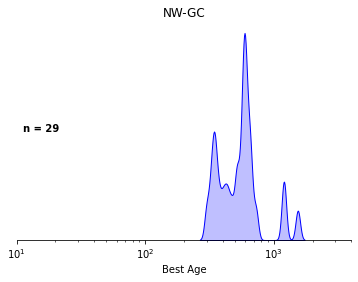

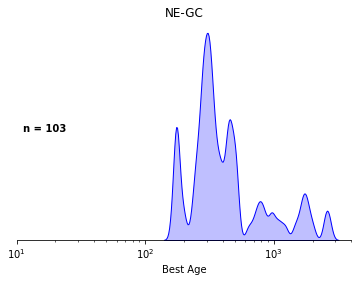

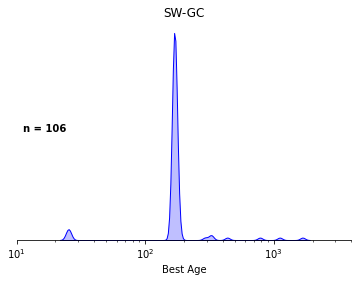

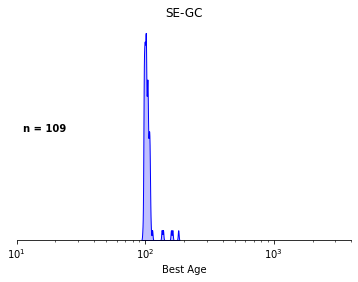

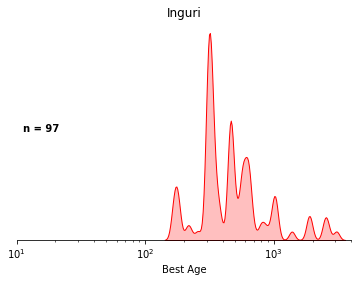

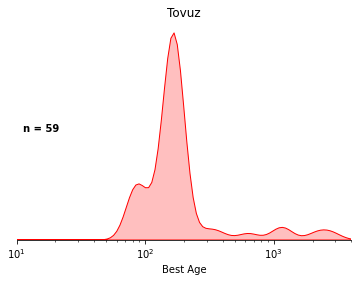

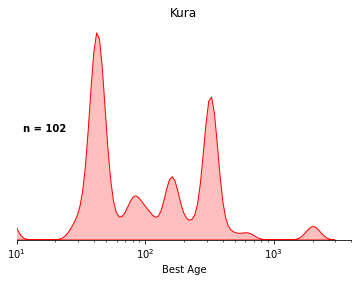

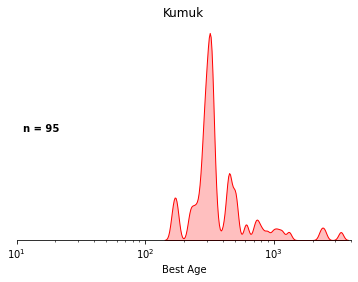

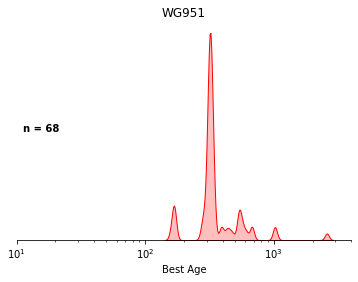

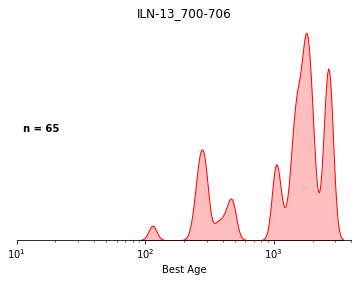

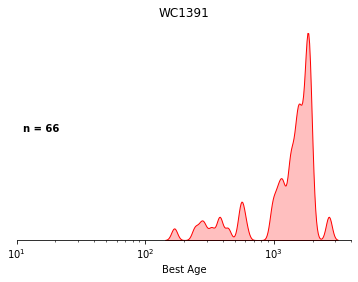

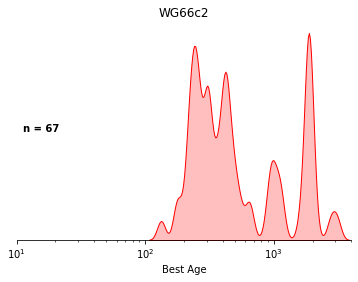

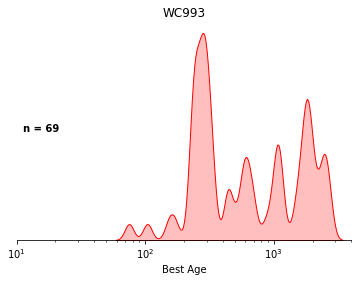

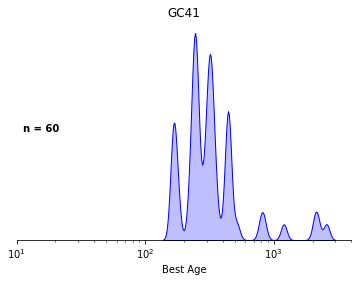

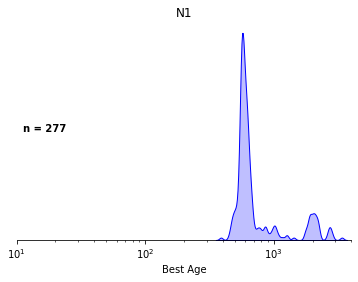

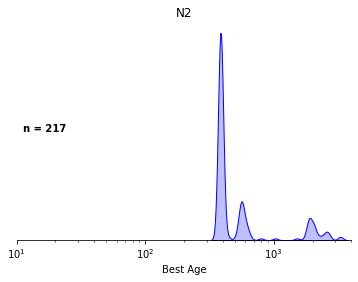

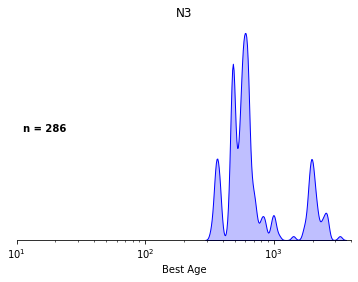

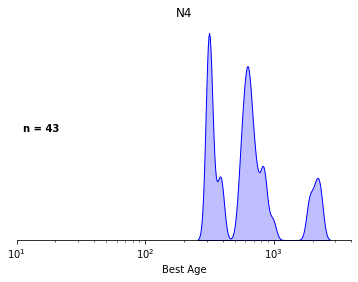

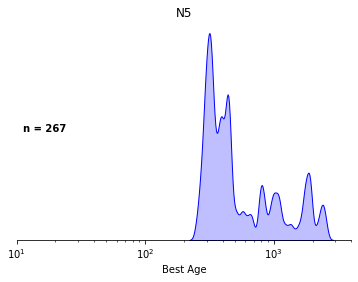

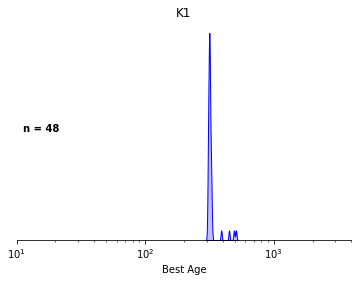

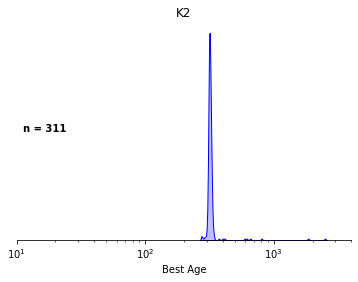

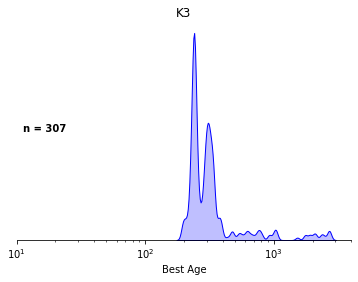

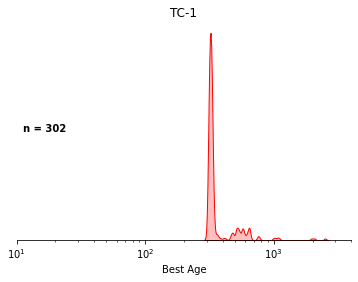

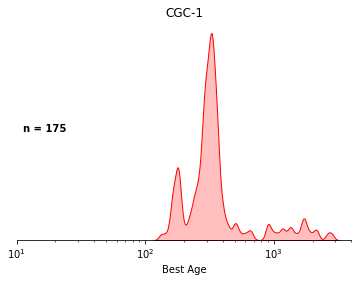

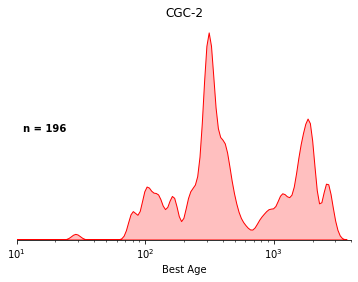

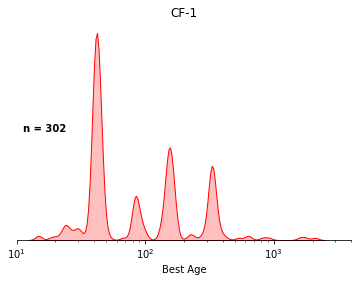

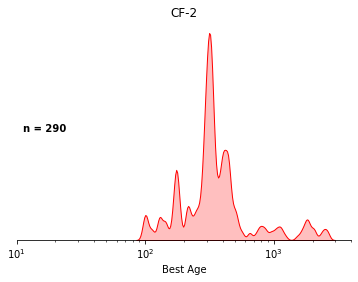

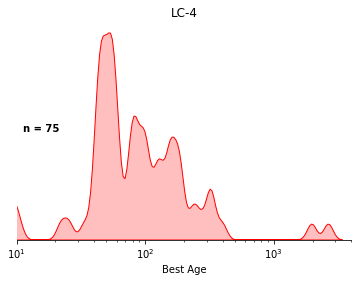

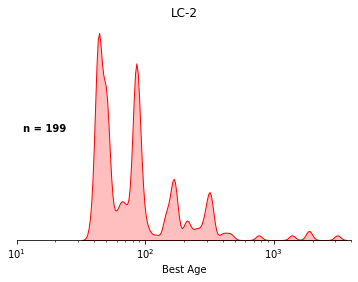

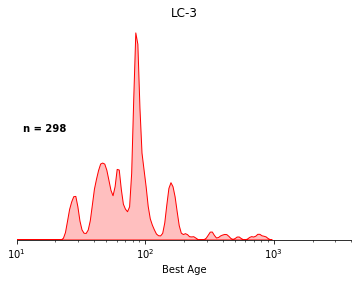

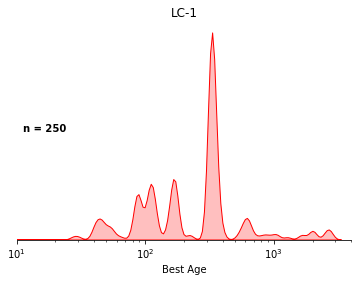

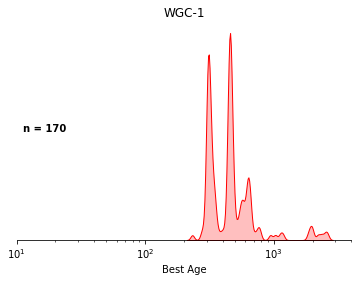

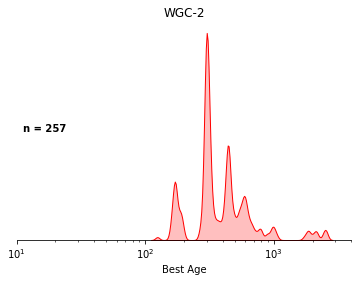

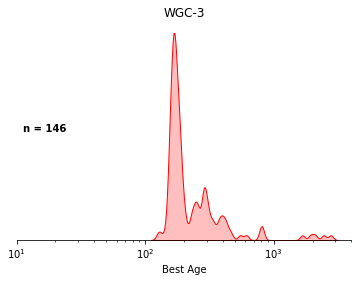

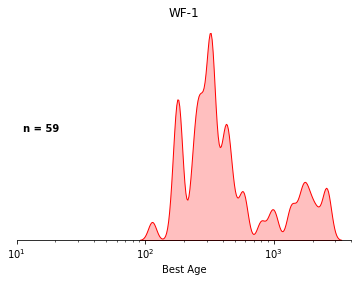

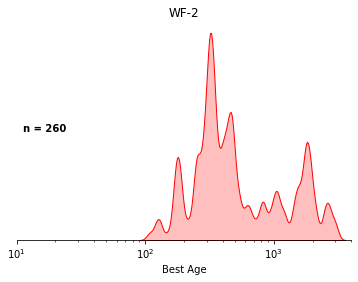

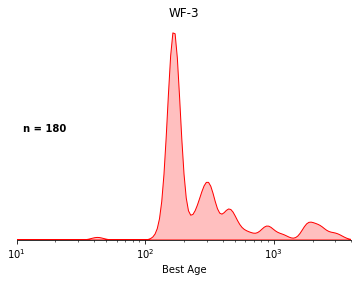

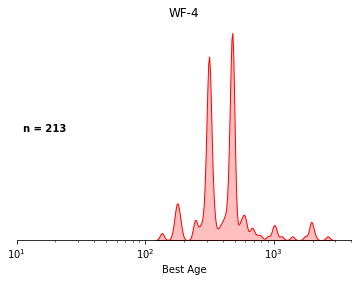

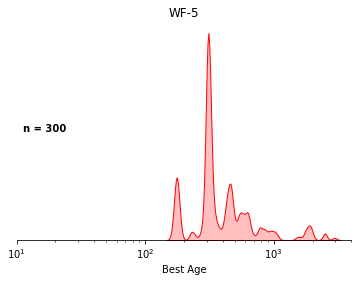

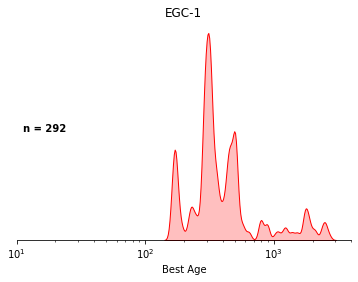

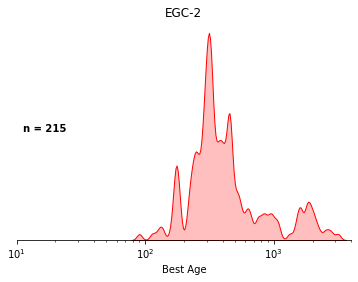

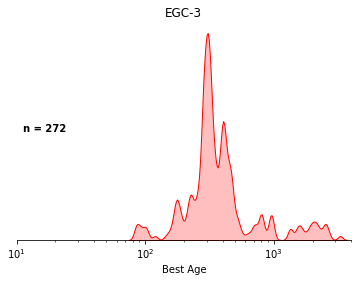

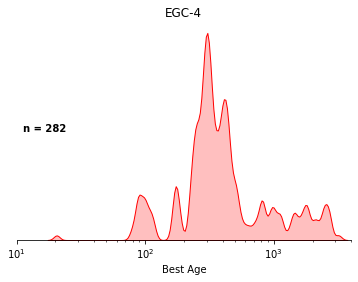

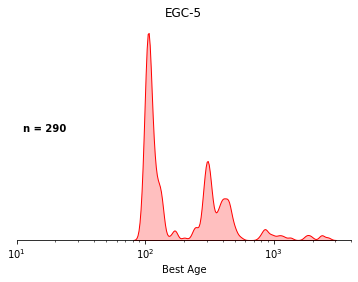

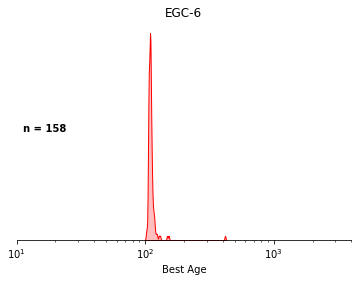

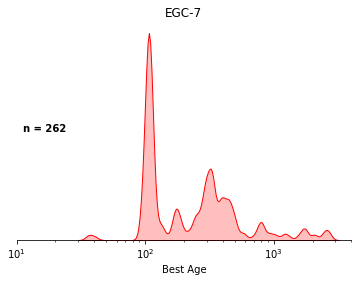

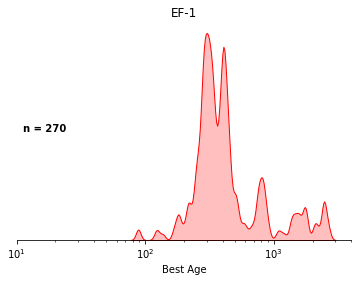

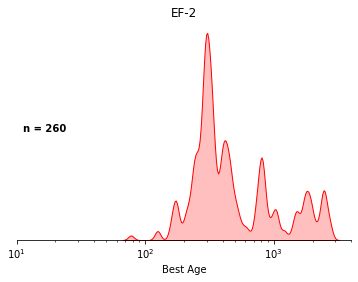

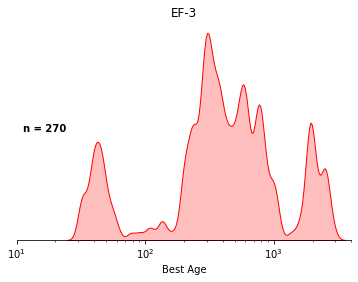

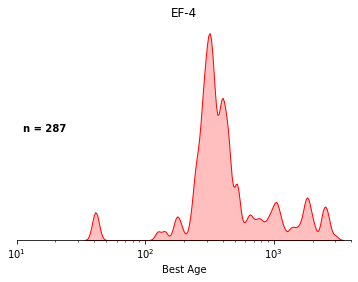

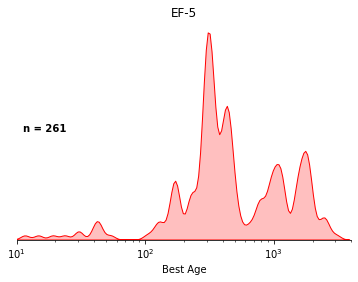

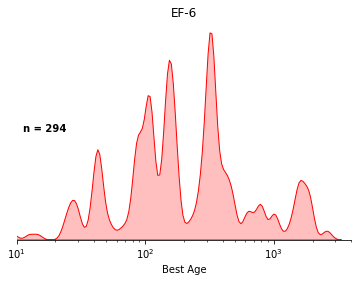

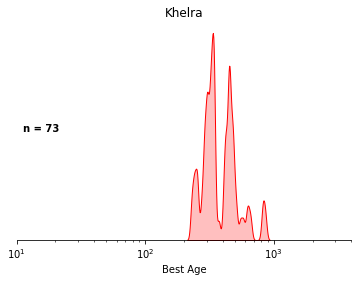

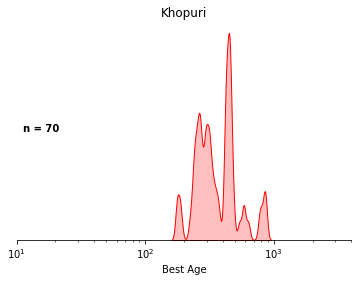

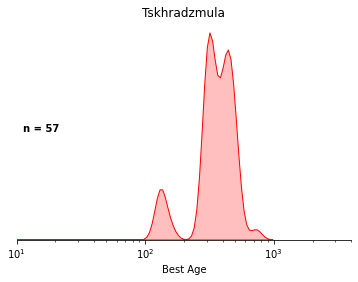

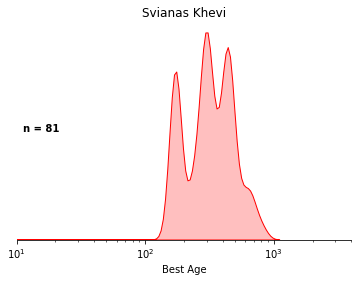

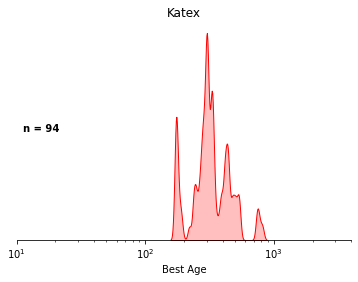

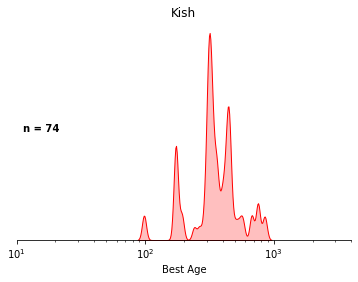

In [ ]:
#%% Populate Objects with Age Data

paths = [sources[x] + '/' + name + '.xlsx' for x,name in enumerate(names)]

for x,sample in enumerate(samples):
    sample.agedata = pd.read_excel(paths[x])
    
    if '206/207 Pb Age' not in sample.agedata:
        sample.agedata['206/207 Pb Age'] = np.nan
    
    sample.calc_bestage('238/206 U-Pb Age','206/207 Pb Age')
    
    sample.kde_img()
    sample.export_ages()

This cell saves the data in the DZ objects to a SHP file for GIS

In [4]:
#%% Save to Shapefile

gdf = dz.write_file(samples,'caucasus_dz.shp')

C:\Users\dyvas\Box\Leslie-CaucasusThesis\DZ_Data\Compiled_Data\dz.py:320: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(filename,crs='EPSG:4326')
